In [3]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import os 
from models.unet import UNet


In [9]:
results = torch.load('trained_model/unet_midv_adam_5.pt')

In [10]:
results['optimizer_state_dict']

{'state': {140444624332048: {'momentum_buffer': tensor([[[[-2.8699e-03, -8.1832e-04, -8.7492e-04],
             [-4.8890e-04,  1.7662e-03,  1.7906e-03],
             [ 7.8097e-04,  3.5759e-03,  3.4594e-03]],
   
            [[-1.9730e-05,  3.6042e-03,  3.5603e-03],
             [ 3.4701e-03,  7.0069e-03,  6.8271e-03],
             [ 5.6117e-03,  9.7383e-03,  9.3044e-03]],
   
            [[ 5.5772e-03,  1.1437e-02,  1.1283e-02],
             [ 1.0259e-02,  1.5829e-02,  1.5337e-02],
             [ 1.3508e-02,  1.9623e-02,  1.8831e-02]]],
   
   
           [[[ 4.5038e-02,  4.7125e-02,  4.4804e-02],
             [ 4.6789e-02,  4.8903e-02,  4.6084e-02],
             [ 4.6276e-02,  4.8091e-02,  4.6036e-02]],
   
            [[ 9.1316e-02,  9.4121e-02,  9.0769e-02],
             [ 9.2745e-02,  9.5477e-02,  9.1619e-02],
             [ 9.1088e-02,  9.3532e-02,  9.0678e-02]],
   
            [[ 1.5657e-01,  1.6020e-01,  1.5542e-01],
             [ 1.5759e-01,  1.6127e-01,  1.5622e-01],
       

In [11]:
results['scheduler_state_dict']

{'step_size': 30,
 'gamma': 0.1,
 'base_lrs': [0.0001],
 'last_epoch': 12600,
 '_step_count': 12601,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.0]}

In [12]:
model = UNet(n_class = 1)
model.load_state_dict(results['model_state_dict'])
model = nn.Sequential(model, nn.Sigmoid())
model.eval()
model.float();
model.cuda()

Sequential(
  (0): UNet(
    (dconv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(i

In [13]:
torch.cuda.empty_cache()

In [14]:
# example images 
import albumentations
import matplotlib.pyplot as plt
import cv2 
import numpy as np 

image = cv2.imread('data_processed/images/{}'.format(np.random.choice(os.listdir('data_processed/images'))))
#image = transform(image)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [15]:
transform = albumentations.Compose([albumentations.LongestMaxSize(max_size=512, p=1), 
                          albumentations.Normalize(p=1)], p=1)

#image, pads = pad(image, factor=768)

image = transform(image=image)["image"]
image = np.moveaxis(image, -1, 0)

In [16]:
output = model(torch.from_numpy(image).unsqueeze(0).float().cuda())

In [17]:
_image= output.squeeze(0)

In [18]:
import albumentations 
import cv2
from src.dataset import MidvDataset
from pathlib import Path 
import torch
from torch.utils.data import DataLoader 
from torch.optim import Adam 
import matplotlib.pyplot as plt

In [19]:
list_images = list(Path('data_processed/images').rglob('*.jpg'))
list_masks = list(Path('data_processed/labels').rglob('*.png'))
list_images = [str(el) for el in list_images]
list_masks = [str(el) for el in list_masks]

samples = list(zip(list_images, list_masks))
samples = [tuple(el) for el in samples]

In [54]:
dataset = MidvDataset(samples = samples, transform = albumentations.Compose( [albumentations.LongestMaxSize(max_size=128 , p=1)], p=1  ))
train_dt, test_dt = torch.utils.data.random_split(dataset,[ int(0.8* len(dataset)), int(0.2* len(dataset))])
train_loader = DataLoader(train_dt,  batch_size = 4, shuffle = True, num_workers = 0)
test_loader = DataLoader(test_dt, shuffle = True, batch_size = 4)

In [56]:
out = model(next(iter(train_loader))['features'].float().cuda() )

In [58]:
out

tensor([[[[0.6284, 0.8414, 0.8788,  ..., 0.9229, 0.8786, 0.7167],
          [0.7327, 0.9030, 0.9574,  ..., 0.9804, 0.9732, 0.9121],
          [0.7661, 0.9405, 0.9804,  ..., 0.9905, 0.9812, 0.9386],
          ...,
          [0.7230, 0.9130, 0.9692,  ..., 0.9953, 0.9889, 0.9415],
          [0.7140, 0.9114, 0.9578,  ..., 0.9880, 0.9694, 0.9087],
          [0.5555, 0.7255, 0.7860,  ..., 0.8917, 0.8582, 0.8089]]],


        [[[0.7228, 0.8997, 0.9498,  ..., 0.9118, 0.8393, 0.6703],
          [0.8259, 0.9650, 0.9903,  ..., 0.9731, 0.9363, 0.8166],
          [0.8612, 0.9851, 0.9983,  ..., 0.9906, 0.9667, 0.8561],
          ...,
          [0.8823, 0.9786, 0.9961,  ..., 0.9766, 0.9591, 0.8589],
          [0.8649, 0.9683, 0.9892,  ..., 0.9564, 0.9320, 0.8305],
          [0.6529, 0.8221, 0.8961,  ..., 0.8017, 0.7864, 0.7511]]],


        [[[0.6241, 0.8293, 0.8597,  ..., 0.8825, 0.8392, 0.6872],
          [0.7106, 0.8862, 0.9443,  ..., 0.9612, 0.9500, 0.8729],
          [0.7418, 0.9269, 0.9699,  ..

In [57]:
out_numpy = out.squeeze(0)[0][0].cpu().detach().numpy()

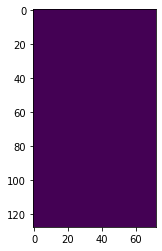

In [53]:
plt.imshow((out_numpy > 0.5))

In [28]:
[plt.imshow(example_image)

SyntaxError: unexpected EOF while parsing (<ipython-input-28-e4758d780bbd>, line 1)

In [ ]:
plt.imshow(example_mask)

In [ ]:
transformed = transform(image = example_image, mask = example_mask)

In [ ]:
from pytorch_toolbelt.utils.torch_utils import tensor_from_rgb_image

In [ ]:
model(tensor_from_rgb_image(transformed['image']))

In [ ]:
import numpy as np 

In [ ]:
mask = (transformed['mask'] > 0).astype(np.uint8)

In [ ]:
np.unique(mask)

In [ ]:
mask = torch.from_numpy(mask)

In [ ]:
transform = albumentations.Compose([albumentations.LongestMaxSize(max_size=512, p=1), 
                          albumentations.Normalize(p=1)], p=1)

In [ ]:
image.shape

In [ ]:
plt.imshow(torch.from_numpy(mask).unsqueeze(0).numpy()[0, :, :])

In [ ]:
### Check for masks lack of information 

In [ ]:
model = model.cuda()
criterion = JaccardLoss(mode="binary", from_logits=True)

for epoch in range(num_epochs):
    model.train()
    for i, res in enumerate(train_loader, 0):
        inputs = res['features'].float().cuda()
        labels = res['masks'].long().cuda()
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
